In [1]:
import phate
import scprep
import seaborn as sns
import os
import json
from PIL import Image, ImageDraw
import re
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
import tifffile as tiff
from tqdm import tqdm
from skimage.exposure import equalize_adapthist
from scipy.stats import stats
import matplotlib.animation as animation
import pandas as pd
import csv
import shutil
from skimage.morphology import dilation, erosion
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage import measure
from skimage.measure import regionprops, label
from scipy.spatial import distance
import time
import datetime
from mpl_toolkits.mplot3d import Axes3D  # 3D Plotting
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score

from skimage.morphology import dilation, erosion
from skimage import measure
from scipy.ndimage import center_of_mass
from glob import glob
import random
from skimage.measure import regionprops, label
from scipy.spatial import distance

import imageio.v2 as imageio
from tifffile import imread

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# Final Regression model

In [16]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os

# === CONFIGURATION ===
input_path = "/home/MinaHossain/EmbedTrack/Track_HP4_Result_Shape/Median/Cells_Centroid_Velocity_TrueLabel_MA_Median_5.csv"
output_root = "/home/MinaHossain/EmbedTrack/Track_HP4_Result_Shape/Median"
plot_dir = f"{output_root}/Reg_Results"
os.makedirs(plot_dir, exist_ok=True)

# === LOAD AND CLEAN DATA ===
df = pd.read_csv(input_path)
collinear_features = ['Area_MA', 'Perimeter_MA', 'Solidity_MA', 'Extent_MA','Circularity_MA', 'Convexity_MA', 'Elongation_MA', 'Compactness_MA']
target_col = 'X_Centroid_Velocity_MA'
df_clean = df[collinear_features + [target_col]].dropna()
X_collinear = df_clean[collinear_features].values
y = df_clean[target_col].values

# === SPLIT DATA (Train/Test Only) ===
X_train, X_test, y_train, y_test = train_test_split(X_collinear, y, test_size=0.2, random_state=42)

# # === SCALING ONLY (NO PCA) ===
# scaler = StandardScaler()
# X_train_final = scaler.fit_transform(X_train)
# X_test_final = scaler.transform(X_test)



# === PCA ON TRAIN ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=5)
X_train_final = pca.fit_transform(X_train_scaled)
X_test_final = pca.transform(X_test_scaled)



# === TUNE MODELS USING RANDOMIZED SEARCH ===
tuned_models = {}
param_logs = []

ridge_param_grid = {"alpha": np.logspace(-3, 3, 100)}
ridge_search = RandomizedSearchCV(Ridge(), param_distributions=ridge_param_grid, n_iter=20, cv=3, scoring='r2', random_state=42)
ridge_search.fit(X_train_final, y_train)
tuned_models["Ridge_Tuned"] = ridge_search.best_estimator_
param_logs.append(("Ridge_Tuned", ridge_search.best_params_))

lasso_param_grid = {"alpha": np.logspace(-3, 3, 100), "max_iter": [10000]}
lasso_search = RandomizedSearchCV(Lasso(random_state=42), param_distributions=lasso_param_grid, n_iter=20, cv=3, scoring='r2', random_state=42)
lasso_search.fit(X_train_final, y_train)
tuned_models["Lasso_Tuned"] = lasso_search.best_estimator_
param_logs.append(("Lasso_Tuned", lasso_search.best_params_))

enet_param_grid = {
    "alpha": np.logspace(-3, 3, 50),
    "l1_ratio": np.linspace(0.1, 0.9, 9),
    "max_iter": [10000]
}
enet_search = RandomizedSearchCV(ElasticNet(random_state=42), param_distributions=enet_param_grid, n_iter=30, cv=3, scoring='r2', random_state=42)
enet_search.fit(X_train_final, y_train)
tuned_models["ElasticNet_Tuned"] = enet_search.best_estimator_
param_logs.append(("ElasticNet_Tuned", enet_search.best_params_))

rf_param_grid = {
    "n_estimators": [100, 200, 400],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", "log2"]
}
rf_search = RandomizedSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1),  param_distributions=rf_param_grid, n_iter=30, cv=3, scoring='r2', random_state=42, n_jobs=-1)
rf_search.fit(X_train_final, y_train)
tuned_models["RandomForest_Tuned"] = rf_search.best_estimator_
param_logs.append(("RandomForest_Tuned", rf_search.best_params_))

xgb_param_grid = {
    "n_estimators": [100, 200, 400],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0]
}
xgb_search = RandomizedSearchCV(XGBRegressor(random_state=42, verbosity=0, n_jobs=-1), param_distributions=xgb_param_grid, n_iter=30, cv=3, scoring='r2', random_state=42, n_jobs=-1)
xgb_search.fit(X_train_final, y_train)
tuned_models["XGBoost_Tuned"] = xgb_search.best_estimator_
param_logs.append(("XGBoost_Tuned", xgb_search.best_params_))

tuned_models["LinearRegression_Tuned"] = LinearRegression()
param_logs.append(("LinearRegression_Tuned", "No tuning required"))

# === LOG BEST PARAMS ===
param_df = pd.DataFrame(param_logs, columns=["Model", "Best_Params"])
param_df.to_csv(f"{plot_dir}/best_model_hyperparameters.csv", index=False)

# === EVALUATE TUNED MODELS ON TEST ===
results = {}
all_metrics = []
for name, model in tuned_models.items():
    try:
        model.fit(X_train_final, y_train)
        y_test_pred = model.predict(X_test_final)
        r2 = r2_score(y_test, y_test_pred)
        mse = mean_squared_error(y_test, y_test_pred)
        results[name] = r2
        all_metrics.append({"Model": name, "R2_Test": r2, "MSE_Test": mse})
    except Exception as e:
        results[name] = f"Failed: {str(e)}"

metrics_df_all = pd.DataFrame(all_metrics)
metrics_df_all.to_csv(f"{plot_dir}/all_model_test_metrics.csv", index=False)

# === COMPARISON PLOT ===
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df_all.sort_values("R2_Test", ascending=False), x="R2_Test", y="Model", palette="viridis")
plt.title("Test R² Score by Model")
plt.xlabel("R² Score")
plt.ylabel("Model")
plt.tight_layout()
plt.savefig(f"{plot_dir}/model_comparison_r2_test.png")
plt.close()

# === SELECT AND RETRAIN BEST MODEL FOR TEST SET ===
best_model_name = max(results, key=lambda k: results[k] if isinstance(results[k], float) else -np.inf)
best_model = tuned_models[best_model_name]
best_model.fit(X_train_final, y_train)
y_test_pred = best_model.predict(X_test_final)

print(f"Best Tuned Model: {best_model_name}")

# === FEATURE IMPORTANCE (if available) ===
# === FEATURE IMPORTANCE (if available) ===
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    feat_labels = [f"PC{i+1}" for i in range(len(importances))]
    feat_df = pd.DataFrame({"Feature": feat_labels, "Importance": importances})
    feat_df = feat_df.sort_values(by="Importance", ascending=False)
    feat_df.to_csv(f"{plot_dir}/best_model_feature_importances.csv", index=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feat_df, x="Importance", y="Feature", palette="crest")
    plt.title("Feature Importances - Best Model")
    plt.tight_layout()
    plt.savefig(f"{plot_dir}/best_model_feature_importance_plot.png")
    plt.close()




# # === PLOTTING ===
def plot_results(y_true, y_pred):
    residuals = y_true - y_pred
    absolute_errors = np.abs(residuals)

    def save_plot(fig, name):
        fig.tight_layout()
        fig.savefig(f"{plot_dir}/{name}.png")
        plt.close(fig)

    fig, ax = plt.subplots(figsize=(8, 5))
    sns.scatterplot(x=y_pred, y=residuals, ax=ax)
    ax.axhline(0, linestyle='--', color='red')
    ax.set_title("Residuals vs Predicted")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residuals")
    save_plot(fig, "residuals_vs_predicted")

    fig, ax = plt.subplots(figsize=(8, 5))
    sns.scatterplot(x=y_true, y=y_pred, ax=ax)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], linestyle='--', color='red')
    ax.set_title("Predicted vs Actual")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    save_plot(fig, "predicted_vs_actual")

    fig, ax = plt.subplots(figsize=(8, 5))
    sns.histplot(residuals, bins=30, kde=True, ax=ax)
    ax.set_title("Distribution of Residuals")
    ax.set_xlabel("Residuals")
    save_plot(fig, "residuals_distribution")

    fig, ax = plt.subplots(figsize=(8, 5))
    sorted_errors = np.sort(absolute_errors)
    cum_dist = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
    ax.plot(sorted_errors, cum_dist)
    ax.set_title("Cumulative Distribution of Absolute Errors")
    ax.set_xlabel("Absolute Error")
    ax.set_ylabel("Cumulative Proportion")
    save_plot(fig, "cumulative_absolute_errors")

    fig = plt.figure(figsize=(6, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Q-Q Plot of Residuals")
    save_plot(fig, "qq_plot_residuals")

    fig, ax = plt.subplots(figsize=(8, 5))
    sns.scatterplot(x=y_true, y=absolute_errors, ax=ax)
    ax.set_title("Absolute Error vs Actual Value")
    ax.set_xlabel("Actual Values")
    ax.set_ylabel("Absolute Error")
    save_plot(fig, "absolute_error_vs_actual")

plot_results(y_test, y_test_pred)

# === PRINT FINAL TEST METRICS ===
r2 = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
print(f"Test R² Score: {r2:.4f}")
print(f"Test Mean Squared Error: {mse:.4f}")

pred_df = pd.DataFrame({
    "True": y_test,
    "Predicted": y_test_pred
})
pred_df.to_csv(f"{plot_dir}/best_model_predictions.csv", index=False)




Exception ignored in: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/MinaHossain/anaconda3/envs/Shp_chc/lib/python3.12/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 155, in <module>
Traceback (most recent call last):
  File "<frozen runpy>", line 189, in _run_module_as_main
  File "<frozen runpy>", line 112, in _get_module_details
  File "/home/MinaHossain/anaconda3/envs/Shp_chc/lib/python3.12/site-packages/joblib/__init__.py", line 114, in <module>
Traceback (most recent call last):
  File "<frozen runpy>", line 189, in _run_module_as_main
  File "<frozen runpy>", line 112, in _get_module_details
  File "/home/MinaHossain/anaconda3/envs/Shp_chc/lib/python3.12/site-packages/joblib/__init__.py", line 114, in <module>
Traceback (most recent call last):
  File "<frozen runpy>", line 189, in _run_module_as_main
  File "<frozen runpy>", line 112, in _get_module

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:


# === CONFIGURATION ===
input_path = "/home/MinaHossain/EmbedTrack/Track_HP4_Result_Shape/Median/Cells_Centroid_Velocity_TrueLabel_MA_Median_5.csv"
output_root = "/home/MinaHossain/EmbedTrack/Track_HP4_Result_Shape/Median"
plot_dir = f"{output_root}/Ridge_Plots"
os.makedirs(plot_dir, exist_ok=True)

# === LOAD AND CLEAN DATA ===
df = pd.read_csv(input_path)
collinear_features = ['Area_MA', 'Perimeter_MA', 'Solidity_MA', 'Extent_MA',
                      'Circularity_MA', 'Convexity_MA', 'Elongation_MA', 'Compactness_MA']
# spatial_features = ['Centroid_X_MA', 'Centroid_Y_MA', 'X_Centroid_Distance_MA', 'Y_Centroid_Distance_MA']
spatial_features = ['Centroid_Y_MA',  'Y_Centroid_Distance_MA']
target_col = 'X_Centroid_Velocity_MA'

df_clean = df[collinear_features + spatial_features + [target_col]].dropna()
X_collinear = df_clean[collinear_features].values
X_spatial = df_clean[spatial_features].values
y = df_clean[target_col].values

# === SPLIT DATA ===
X_col_train, X_col_temp, X_spatial_train, X_spatial_temp, y_train, y_temp = train_test_split(
    X_collinear, X_spatial, y, test_size=0.5, random_state=42)
X_col_val, X_col_test, X_spatial_val, X_spatial_test, y_val, y_test = train_test_split(
    X_col_temp, X_spatial_temp, y_temp, test_size=0.5, random_state=42)

# === PCA ON TRAIN ===
scaler = StandardScaler()
X_col_train_scaled = scaler.fit_transform(X_col_train)
X_col_val_scaled = scaler.transform(X_col_val)
X_col_test_scaled = scaler.transform(X_col_test)

pca = PCA(n_components=3)
X_pca_train = pca.fit_transform(X_col_train_scaled)
X_pca_val = pca.transform(X_col_val_scaled)
X_pca_test = pca.transform(X_col_test_scaled)

X_train_final = np.hstack([X_pca_train, X_spatial_train])
X_val_final = np.hstack([X_pca_val, X_spatial_val])
X_test_final = np.hstack([X_pca_test, X_spatial_test])

# === DEFINE MODELS ===
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5),
    "Lasso": LassoCV(cv=5, random_state=42, max_iter=10000),
    "ElasticNet": ElasticNetCV(cv=5, random_state=42, max_iter=10000),
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.01, random_state=42, n_jobs=-1, verbosity=0)
}

# === EVALUATE MODELS ON VALIDATION SET ===
results = {}
for name, model in models.items():
    try:
        model.fit(X_train_final, y_train)
        y_val_pred = model.predict(X_val_final)
        r2 = r2_score(y_val, y_val_pred)
        results[name] = r2
    except Exception as e:
        results[name] = f"Failed: {str(e)}"

best_model_name = max(results, key=lambda k: results[k] if isinstance(results[k], float) else -np.inf)
best_model = models[best_model_name]
best_model.fit(X_train_final, y_train)
y_test_pred = best_model.predict(X_test_final)

# === SAVE COEFFICIENTS AND PERFORMANCE ===
coeff_labels = [f'PC{i+1}' for i in range(3)] + spatial_features
coef_df = pd.DataFrame({'Feature': coeff_labels, 'Coefficient': best_model.coef_}) if hasattr(best_model, 'coef_') else pd.DataFrame()
metrics_df = pd.DataFrame({
    'Metric': ['R-squared', 'MSE'],
    'Value': [r2_score(y_test, y_test_pred), mean_squared_error(y_test, y_test_pred)]
})
coef_df.to_csv(f"{plot_dir}/best_model_coefficients.csv", index=False)
metrics_df.to_csv(f"{plot_dir}/best_model_metrics.csv", index=False)

# === PLOTTING ===
def plot_results(y_true, y_pred):
    residuals = y_true - y_pred
    absolute_errors = np.abs(residuals)

    def save_plot(fig, name):
        fig.tight_layout()
        fig.savefig(f"{plot_dir}/{name}.png")
        plt.close(fig)

    fig, ax = plt.subplots(figsize=(8, 5))
    sns.scatterplot(x=y_pred, y=residuals, ax=ax)
    ax.axhline(0, linestyle='--', color='red')
    ax.set_title("Residuals vs Predicted")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residuals")
    save_plot(fig, "residuals_vs_predicted")

    fig, ax = plt.subplots(figsize=(8, 5))
    sns.scatterplot(x=y_true, y=y_pred, ax=ax)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], linestyle='--', color='red')
    ax.set_title("Predicted vs Actual")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    save_plot(fig, "predicted_vs_actual")

    fig, ax = plt.subplots(figsize=(8, 5))
    sns.histplot(residuals, bins=30, kde=True, ax=ax)
    ax.set_title("Distribution of Residuals")
    ax.set_xlabel("Residuals")
    save_plot(fig, "residuals_distribution")

    fig, ax = plt.subplots(figsize=(8, 5))
    sorted_errors = np.sort(absolute_errors)
    cum_dist = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
    ax.plot(sorted_errors, cum_dist)
    ax.set_title("Cumulative Distribution of Absolute Errors")
    ax.set_xlabel("Absolute Error")
    ax.set_ylabel("Cumulative Proportion")
    save_plot(fig, "cumulative_absolute_errors")

    fig = plt.figure(figsize=(6, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Q-Q Plot of Residuals")
    save_plot(fig, "qq_plot_residuals")

    fig, ax = plt.subplots(figsize=(8, 5))
    sns.scatterplot(x=y_true, y=absolute_errors, ax=ax)
    ax.set_title("Absolute Error vs Actual Value")
    ax.set_xlabel("Actual Values")
    ax.set_ylabel("Absolute Error")
    save_plot(fig, "absolute_error_vs_actual")

plot_results(y_test, y_test_pred)

# === REPORT ON SPLITS ===
y_train_pred = best_model.predict(X_train_final)
y_val_pred = best_model.predict(X_val_final)
y_test_pred = best_model.predict(X_test_final)

performance = pd.DataFrame({
    "Split": ["Train", "Validation", "Test"],
    "R-squared": [
        r2_score(y_train, y_train_pred),
        r2_score(y_val, y_val_pred),
        r2_score(y_test, y_test_pred)
    ],
    "MSE": [
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_val, y_val_pred),
        mean_squared_error(y_test, y_test_pred)
    ]
})

performance.to_csv(f"{plot_dir}/model_performance_by_split.csv", index=False)
print(f"Best model: {best_model_name}")
print(performance)


# Generate the code block for PCA + Clustering using validation data and applying to test data


# === PCA + KMeans CLUSTERING (Fit on Validation, Apply to Test) ===
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

output_directory = plot_dir
window_size = 5

# --- Fit PCA on Validation Set ---
X_scaled_val = X_col_val_scaled
pca_full = PCA()
pca_full.fit(X_scaled_val)
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

optimal_components = np.argmax(cumulative_variance >= 0.95) + 1

# --- Plot PCA Cumulative Variance (Elbow Plot) ---
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='s', linestyle='-', color='red', label="Cumulative Variance")
plt.axvline(x=optimal_components, color='green', linestyle='--', label=f"Optimal Components ({optimal_components})")
plt.scatter(optimal_components, cumulative_variance[optimal_components-1], color='black', s=50, label="Chosen Point")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Elbow Plot with Cumulative Variance")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(output_directory, f"PCA_Elbow_Plot_{window_size}.png"))
plt.close()

# --- Fit 2D PCA on Validation ---
pca_2d = PCA(n_components=2)
pca_val_2d = pca_2d.fit_transform(X_scaled_val)

# --- KMeans on 2D PCA space (Validation) ---
silhouette_scores = []
k_range = range(2, 15)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(pca_val_2d)
    score = silhouette_score(pca_val_2d, kmeans.labels_)
    silhouette_scores.append(score)

optimal_k = k_range[np.argmax(silhouette_scores)]
optimal_score = max(silhouette_scores)

# --- Plot Silhouette Scores ---
plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-', color='purple', label="Silhouette Score")
plt.axvline(x=optimal_k, color='green', linestyle='--', label=f"Optimal k = {optimal_k}")
plt.scatter(optimal_k, optimal_score, color='red', s=100, zorder=5)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters (Validation)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_directory, f"Silhouette_Score_vs_K_{window_size}.png"))
plt.close()

# --- Apply to Test Data ---
X_scaled_test = X_col_test_scaled
pca_test_2d = pca_2d.transform(X_scaled_test)
kmeans_final = KMeans(n_clusters=optimal_k, random_state=0, n_init='auto').fit(pca_val_2d)
test_clusters = kmeans_final.predict(pca_test_2d)

# --- Create Test DataFrame with PCA + Clusters ---
pca_test_df = pd.DataFrame(pca_test_2d, columns=["PCA1", "PCA2"])
pca_test_df["X_Centroid_Velocity_MA"] = X_col_test[:, 0]  # Area_MA is first collinear feature
pca_test_df["Cluster"] = test_clusters

# --- Clustered 2D PCA (Colored by Area) ---
vmin = np.percentile(pca_test_df["X_Centroid_Velocity_MA"], 5)
vmax = np.percentile(pca_test_df["X_Centroid_Velocity_MA"], 95)
plt.figure(figsize=(10, 7))
sc = plt.scatter(pca_test_df["PCA1"], pca_test_df["PCA2"], c=pca_test_df["X_Centroid_Velocity_MA"], cmap="plasma", alpha=0.8, vmin=vmin, vmax=vmax)
plt.colorbar(sc, label="X_Centroid Velocity (MA)")
plt.title("2D PCA Test Data Colored by X_Centroid Velocity(MA)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_directory, f"PCA_2D_X_Centroid_Velocity_MA_{window_size}.png"))
plt.close()

# --- Cluster Plot with Centers ---
plt.figure(figsize=(10, 7))
plt.scatter(pca_test_df["PCA1"], pca_test_df["PCA2"], c=pca_test_df["Cluster"], cmap="tab10", alpha=0.8)
centers = kmeans_final.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, marker='o', label='Centers')
for idx, (x, y) in enumerate(centers):
    plt.text(x, y, str(idx), fontsize=12, fontweight='bold', ha='center', va='center', color='white',
             bbox=dict(facecolor='black', boxstyle='circle,pad=0.2'))
plt.title(f"Test Data PCA with KMeans Clusters (k={optimal_k})")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_directory, f"PCA_2D_Clusters_X_Centroid_Velocity_MA_{window_size}.png"))
plt.close()

# --- Boxplot: Area by Cluster (Test Data) ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=pca_test_df, x="Cluster", y="X_Centroid_Velocity_MA", palette="Set2")
sns.stripplot(data=pca_test_df, x="Cluster", y="X_Centroid_Velocity_MA", color='gray', alpha=0.5, jitter=0.2, size=3)
plt.title("X_Centroid Velocity (MA) by Cluster (Test Data)", fontsize=14)
plt.xlabel("Cluster")
plt.ylabel("X_Centroid Velocity (MA)")
plt.tight_layout()
plt.savefig(os.path.join(output_directory, f"Boxplot_X_Centroid_Velocity_MA_By_Cluster_{window_size}.png"))
plt.close()

# --- Save clustered PCA test data and summary ---
pca_test_df.to_csv(os.path.join(output_directory, f"PCA_Cluster_Results_Test_{window_size}.csv"), index=False)

summary = pca_test_df.groupby("Cluster").agg({
    "PCA1": ["mean", "std"],
    "PCA2": ["mean", "std"],
    "X_Centroid_Velocity_MA": ["mean", "std"]
}).reset_index()
summary.columns = ["_".join(col).strip("_") for col in summary.columns.values]
summary.to_csv(os.path.join(output_directory, f"PCA_Cluster_Summary_Test_{window_size}.csv"), index=False)


Best model: RandomForest
        Split  R-squared        MSE
0       Train   0.851260  21.423358
1  Validation   0.692919  65.089067
2        Test   0.109408  51.414964


/tmp/ipykernel_3045944/3060033429.py:262: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pca_test_df, x="Cluster", y="X_Centroid_Velocity_MA", palette="Set2")


# Create the updated FNN pipeline script content with PCA + spatial features + grid search

In [17]:


import os
import argparse
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from itertools import product

# --- CONFIG ---
output_root = "/home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Median/Reg_Analysis_FNN_PCA"
os.makedirs(f"{output_root}/models", exist_ok=True)
os.makedirs(f"{output_root}/results", exist_ok=True)
os.makedirs(f"{output_root}/plots", exist_ok=True)

# --- FNN Model ---
class FNN(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(FNN, self).__init__()
        layers = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU()]
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# --- Evaluation ---
def evaluate_model(model, X_test_tensor, y_test_tensor):
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.cpu().numpy().flatten()
    y_true = y_test_tensor.cpu().numpy().flatten()
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"✅ MSE: {mse:.4f} | R²: {r2:.4f}")
    return mse, r2, y_true, y_pred

# --- Plotting ---
def plot_results(y_true, y_pred, train_losses=None):
    residuals = y_true - y_pred
    if train_losses:
        plt.figure(); plt.plot(train_losses); plt.title("Training Loss"); plt.tight_layout()
        plt.savefig(f"{output_root}/plots/loss_curve.png"); plt.close()
    plt.figure(); sns.scatterplot(x=y_pred, y=residuals); plt.axhline(0, linestyle='--', color='red')
    plt.title("Residuals vs Predicted"); plt.tight_layout()
    plt.savefig(f"{output_root}/plots/residuals_vs_predicted.png"); plt.close()
    plt.figure(); sns.scatterplot(x=y_true, y=y_pred); plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.title("Predicted vs Actual"); plt.tight_layout()
    plt.savefig(f"{output_root}/plots/predicted_vs_actual.png"); plt.close()
    plt.figure(); sns.histplot(residuals, bins=30, kde=True)
    plt.title("Distribution of Residuals"); plt.tight_layout()
    plt.savefig(f"{output_root}/plots/residuals_distribution.png"); plt.close()
    plt.figure(); plt.plot(np.sort(np.abs(residuals)), np.linspace(0, 1, len(residuals)))
    plt.title("Cumulative Absolute Errors"); plt.tight_layout()
    plt.savefig(f"{output_root}/plots/cumulative_absolute_errors.png"); plt.close()
    plt.figure(); stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Q-Q Plot"); plt.tight_layout()
    plt.savefig(f"{output_root}/plots/qq_plot_residuals.png"); plt.close()
    plt.figure(); sns.scatterplot(x=y_true, y=np.abs(residuals))
    plt.title("Absolute Error vs Actual"); plt.tight_layout()
    plt.savefig(f"{output_root}/plots/absolute_error_vs_actual.png"); plt.close()

# --- Run FNN ---
def run_fnn(X_train,  X_test, y_train,  y_test, input_size, hidden_sizes, lr, batch_size, epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FNN(input_size=input_size, hidden_sizes=hidden_sizes).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train).float().to(device)
    y_train_tensor = torch.tensor(y_train).float().to(device)
    # X_val_tensor = torch.tensor(X_val).float().to(device)
    # y_val_tensor = torch.tensor(y_val).float().to(device)
    X_test_tensor = torch.tensor(X_test).float().to(device)
    y_test_tensor = torch.tensor(y_test).float().to(device)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)

    train_losses = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}: Loss={train_losses[-1]:.4f}")

    return model, train_losses, X_test_tensor, y_test_tensor

# --- Grid Search ---
def grid_search_fnn(csv_path, param_grid):
    df = pd.read_csv(csv_path)
    shape_features = ['Area_MA', 'Perimeter_MA', 'Extent_MA', 'Solidity_MA', 'Compactness_MA', 'Elongation_MA', 'Circularity_MA', 'Convexity_MA']
    # spatial_features = ['Centroid_X_MA', 'Centroid_Y_MA', 'X_Centroid_Distance_MA', 'Y_Centroid_Distance_MA']
    target = 'X_Centroid_Velocity_MA'
    df = df.dropna(subset=shape_features  + [target])

    X_shape = df[shape_features].values
    # X_spatial = df[spatial_features].values
    y = df[target].values.reshape(-1, 1)

    scaler = StandardScaler()
    X_train, X_test, y_train, y_test = train_test_split(X_shape, y, test_size=0.2, random_state=42)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    # PCA
    pca = PCA(n_components=5)
    X_train_final = pca.fit_transform(X_train_scaled)
    X_test_final = pca.transform(X_test_scaled)

    results = []
    best_r2 = -np.inf
    best_model = None
    best_config = None
    best_losses = None
    best_test_tensors = None

    for lr, batch_size, hidden_sizes, epochs in product(param_grid["lr"], param_grid["batch_size"],
                                                        param_grid["hidden_sizes"], param_grid["epochs"]):
        print(f"▶ Training: lr={lr}, batch={batch_size}, hidden={hidden_sizes}, epochs={epochs}")
        model, train_losses, X_test_tensor, y_test_tensor = run_fnn(
            X_train_final,  X_test_final,
            y_train,  y_test,
            input_size=X_train_final.shape[1],
            hidden_sizes=hidden_sizes,
            lr=lr,
            batch_size=batch_size,
            epochs=epochs
        )
        mse, r2, y_true, y_pred = evaluate_model(model, X_test_tensor, y_test_tensor)

        results.append({
            "lr": lr, "batch_size": batch_size, "hidden_sizes": str(hidden_sizes),
            "epochs": epochs, "mse": mse, "r2": r2
        })

        if r2 > best_r2:
            best_r2 = r2
            best_model = model
            best_config = {
                "lr": lr, "batch_size": batch_size,
                "hidden_sizes": hidden_sizes, "epochs": epochs
            }
            best_losses = train_losses
            best_test_tensors = (X_test_tensor, y_test_tensor, y_true, y_pred)

    # Save best model
    model_path = f"{output_root}/models/fnn_best_model.pt"
    torch.save(best_model.state_dict(), model_path)

    pd.DataFrame(results).to_csv(f"{output_root}/results/grid_search_results.csv", index=False)
    print(f"🏆 Best config: {best_config}, R²={best_r2:.4f}")
    return best_model, best_config, best_losses, best_test_tensors

# --- Entry Point ---
if __name__ == "__main__":
    param_grid = {
        "lr": [0.001,0.0001,0.00001,0.000001],
        "batch_size": [8,16,32],
        "hidden_sizes": [(256,128,64),(128, 64, 32), (64, 32, 16),(32,16,8),(64,32,16,8)],
        "epochs": [100, 200,300]
        }
    # csv_path = "/home/MinaHossain/EmbedTrack/Track_EMBD_Result_Shape/Median/Cells_Centroid_Velocity_TrueLabel_MA_Median_5.csv"
    csv_path="/home/MinaHossain/EmbedTrack/Track_HP4_Result_Shape/Median/Cells_Centroid_Velocity_TrueLabel_MA_Median_5.csv"
    best_model, best_config, best_losses, (X_test_tensor, y_test_tensor, y_true, y_pred) = grid_search_fnn(csv_path, param_grid)
    plot_results(y_true, y_pred, train_losses=best_losses)



▶ Training: lr=0.001, batch=8, hidden=(256, 128, 64), epochs=100
Epoch 10: Loss=60.7583
Epoch 20: Loss=48.0488
Epoch 30: Loss=43.0716
Epoch 40: Loss=40.0179
Epoch 50: Loss=34.7239
Epoch 60: Loss=31.8976
Epoch 70: Loss=28.8628
Epoch 80: Loss=29.4072
Epoch 90: Loss=25.7802
Epoch 100: Loss=23.8316
✅ MSE: 48.3614 | R²: 0.6188
▶ Training: lr=0.001, batch=8, hidden=(256, 128, 64), epochs=200
Epoch 10: Loss=77.9203
Epoch 20: Loss=50.3887
Epoch 30: Loss=55.3319
Epoch 40: Loss=40.0342
Epoch 50: Loss=36.6373
Epoch 60: Loss=38.3620
Epoch 70: Loss=28.9798
Epoch 80: Loss=28.3483
Epoch 90: Loss=27.2999
Epoch 100: Loss=25.3773
Epoch 110: Loss=25.6427
Epoch 120: Loss=24.8958
Epoch 130: Loss=21.6184
Epoch 140: Loss=20.2393
Epoch 150: Loss=19.5229
Epoch 160: Loss=18.1424
Epoch 170: Loss=16.8603
Epoch 180: Loss=19.0569
Epoch 190: Loss=17.1586
Epoch 200: Loss=15.4078
✅ MSE: 60.9424 | R²: 0.5196
▶ Training: lr=0.001, batch=8, hidden=(256, 128, 64), epochs=300
Epoch 10: Loss=57.9969
Epoch 20: Loss=47.9169
E

In [8]:


import os
import argparse
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from itertools import product

# --- CONFIG ---
output_root = "/home/MinaHossain/EmbedTrack/Track_EMBD_Result_Shape/Mean/Reg_Analysis_FNN_PCA"
os.makedirs(f"{output_root}/models", exist_ok=True)
os.makedirs(f"{output_root}/results", exist_ok=True)
os.makedirs(f"{output_root}/plots", exist_ok=True)

# --- FNN Model ---
class FNN(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(FNN, self).__init__()
        layers = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU()]
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# --- Evaluation ---
def evaluate_model(model, X_test_tensor, y_test_tensor):
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.cpu().numpy().flatten()
    y_true = y_test_tensor.cpu().numpy().flatten()
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"✅ MSE: {mse:.4f} | R²: {r2:.4f}")
    return mse, r2, y_true, y_pred

# --- Plotting ---
def plot_results(y_true, y_pred, train_losses=None):
    residuals = y_true - y_pred
    if train_losses:
        plt.figure(); plt.plot(train_losses); plt.title("Training Loss"); plt.tight_layout()
        plt.savefig(f"{output_root}/plots/loss_curve.png"); plt.close()
    plt.figure(); sns.scatterplot(x=y_pred, y=residuals); plt.axhline(0, linestyle='--', color='red')
    plt.title("Residuals vs Predicted"); plt.tight_layout()
    plt.savefig(f"{output_root}/plots/residuals_vs_predicted.png"); plt.close()
    plt.figure(); sns.scatterplot(x=y_true, y=y_pred); plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.title("Predicted vs Actual"); plt.tight_layout()
    plt.savefig(f"{output_root}/plots/predicted_vs_actual.png"); plt.close()
    plt.figure(); sns.histplot(residuals, bins=30, kde=True)
    plt.title("Distribution of Residuals"); plt.tight_layout()
    plt.savefig(f"{output_root}/plots/residuals_distribution.png"); plt.close()
    plt.figure(); plt.plot(np.sort(np.abs(residuals)), np.linspace(0, 1, len(residuals)))
    plt.title("Cumulative Absolute Errors"); plt.tight_layout()
    plt.savefig(f"{output_root}/plots/cumulative_absolute_errors.png"); plt.close()
    plt.figure(); stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Q-Q Plot"); plt.tight_layout()
    plt.savefig(f"{output_root}/plots/qq_plot_residuals.png"); plt.close()
    plt.figure(); sns.scatterplot(x=y_true, y=np.abs(residuals))
    plt.title("Absolute Error vs Actual"); plt.tight_layout()
    plt.savefig(f"{output_root}/plots/absolute_error_vs_actual.png"); plt.close()

# --- Run FNN ---
def run_fnn(X_train,  X_test, y_train,  y_test, input_size, hidden_sizes, lr, batch_size, epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FNN(input_size=input_size, hidden_sizes=hidden_sizes).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train).float().to(device)
    y_train_tensor = torch.tensor(y_train).float().to(device)
    # X_val_tensor = torch.tensor(X_val).float().to(device)
    # y_val_tensor = torch.tensor(y_val).float().to(device)
    X_test_tensor = torch.tensor(X_test).float().to(device)
    y_test_tensor = torch.tensor(y_test).float().to(device)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)

    train_losses = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}: Loss={train_losses[-1]:.4f}")

    return model, train_losses, X_test_tensor, y_test_tensor

# --- Grid Search ---
def grid_search_fnn(csv_path, param_grid):
    df = pd.read_csv(csv_path)
    shape_features = ['Area_MA', 'Perimeter_MA', 'Extent_MA', 'Solidity_MA', 'Compactness_MA', 'Elongation_MA', 'Circularity_MA', 'Convexity_MA']
    # spatial_features = ['Centroid_X_MA', 'Centroid_Y_MA', 'X_Centroid_Distance_MA', 'Y_Centroid_Distance_MA']
    target = 'X_Centroid_Velocity_MA'
    df = df.dropna(subset=shape_features  + [target])

    X_shape = df[shape_features].values
    # X_spatial = df[spatial_features].values
    y = df[target].values.reshape(-1, 1)

    scaler = StandardScaler()
    X_train, X_test, y_train, y_test = train_test_split(X_shape, y, test_size=0.2, random_state=42)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    # PCA
    pca = PCA(n_components=5)
    X_train_final = pca.fit_transform(X_train_scaled)
    X_test_final = pca.transform(X_test_scaled)

    results = []
    best_r2 = -np.inf
    best_model = None
    best_config = None
    best_losses = None
    best_test_tensors = None

    for lr, batch_size, hidden_sizes, epochs in product(param_grid["lr"], param_grid["batch_size"],
                                                        param_grid["hidden_sizes"], param_grid["epochs"]):
        print(f"▶ Training: lr={lr}, batch={batch_size}, hidden={hidden_sizes}, epochs={epochs}")
        model, train_losses, X_test_tensor, y_test_tensor = run_fnn(
            X_train_final,  X_test_final,
            y_train,  y_test,
            input_size=X_train_final.shape[1],
            hidden_sizes=hidden_sizes,
            lr=lr,
            batch_size=batch_size,
            epochs=epochs
        )
        mse, r2, y_true, y_pred = evaluate_model(model, X_test_tensor, y_test_tensor)

        results.append({
            "lr": lr, "batch_size": batch_size, "hidden_sizes": str(hidden_sizes),
            "epochs": epochs, "mse": mse, "r2": r2
        })

        if r2 > best_r2:
            best_r2 = r2
            best_model = model
            best_config = {
                "lr": lr, "batch_size": batch_size,
                "hidden_sizes": hidden_sizes, "epochs": epochs
            }
            best_losses = train_losses
            best_test_tensors = (X_test_tensor, y_test_tensor, y_true, y_pred)

    # Save best model
    model_path = f"{output_root}/models/fnn_best_model.pt"
    torch.save(best_model.state_dict(), model_path)

    pd.DataFrame(results).to_csv(f"{output_root}/results/grid_search_results.csv", index=False)
    print(f"🏆 Best config: {best_config}, R²={best_r2:.4f}")
    return best_model, best_config, best_losses, best_test_tensors

# --- Entry Point ---
if __name__ == "__main__":
    param_grid = {
        "lr": [0.001,0.0001,0.00001,0.000001],
        "batch_size": [8,16,32],
        "hidden_sizes": [(256,128,64),(128, 64, 32), (64, 32, 16),(32,16,8),(64,32,16,8)],
        "epochs": [100, 200,300]
        }
    # csv_path = "/home/MinaHossain/EmbedTrack/Track_EMBD_Result_Shape/Median/Cells_Centroid_Velocity_TrueLabel_MA_Median_5.csv"
    csv_path="/home/MinaHossain/EmbedTrack/Track_EMBD_Result_Shape/Mean/Cells_Centroid_Velocity_TrueLabel_MA_Mean_5.csv"
    best_model, best_config, best_losses, (X_test_tensor, y_test_tensor, y_true, y_pred) = grid_search_fnn(csv_path, param_grid)
    plot_results(y_true, y_pred, train_losses=best_losses)



▶ Training: lr=0.001, batch=8, hidden=(256, 128, 64), epochs=100
Epoch 10: Loss=9.8794
Epoch 20: Loss=7.8797
Epoch 30: Loss=6.9414
Epoch 40: Loss=6.4367
Epoch 50: Loss=5.7127
Epoch 60: Loss=5.2809
Epoch 70: Loss=4.7756
Epoch 80: Loss=4.3604
Epoch 90: Loss=5.0203
Epoch 100: Loss=3.7925
✅ MSE: 27.2085 | R²: 0.5242
▶ Training: lr=0.001, batch=8, hidden=(256, 128, 64), epochs=200
Epoch 10: Loss=9.8641
Epoch 20: Loss=8.0648
Epoch 30: Loss=7.1187
Epoch 40: Loss=6.5411
Epoch 50: Loss=5.9334
Epoch 60: Loss=5.5619
Epoch 70: Loss=4.9140
Epoch 80: Loss=4.7105
Epoch 90: Loss=4.9496
Epoch 100: Loss=4.2781
Epoch 110: Loss=3.6354
Epoch 120: Loss=3.4275
Epoch 130: Loss=2.9969
Epoch 140: Loss=3.1025
Epoch 150: Loss=3.7865
Epoch 160: Loss=3.0962
Epoch 170: Loss=3.3816
Epoch 180: Loss=3.2554
Epoch 190: Loss=2.7354
Epoch 200: Loss=2.2934
✅ MSE: 28.2092 | R²: 0.5067
▶ Training: lr=0.001, batch=8, hidden=(256, 128, 64), epochs=300
Epoch 10: Loss=10.4988
Epoch 20: Loss=7.8628
Epoch 30: Loss=7.2374
Epoch 40: 

/home/MinaHossain/anaconda3/envs/Shp_chc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-22 06:19:19,367] A new study created in memory with name: no-name-095538b3-a876-472b-a148-ee61392d6e38
/home/MinaHossain/anaconda3/envs/Shp_chc/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128, 64) which is of type tuple.
  warnings.warn(message)
/home/MinaHossain/anaconda3/envs/Shp_chc/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64, 32) which is of type tuple.
  warnings.warn(message)
/home/


✅ Best R²: 0.02075064182281494
✅ Best hyperparameters: {'hidden_sizes': (128, 64, 32), 'lr': 0.009855181793809537, 'dropout': 0.10908760041629485, 'weight_decay': 0.0007683737495787834, 'batch_size': 8, 'epochs': 300}

🏆 Final Model — MSE: 59.3849 | R²: -0.0284


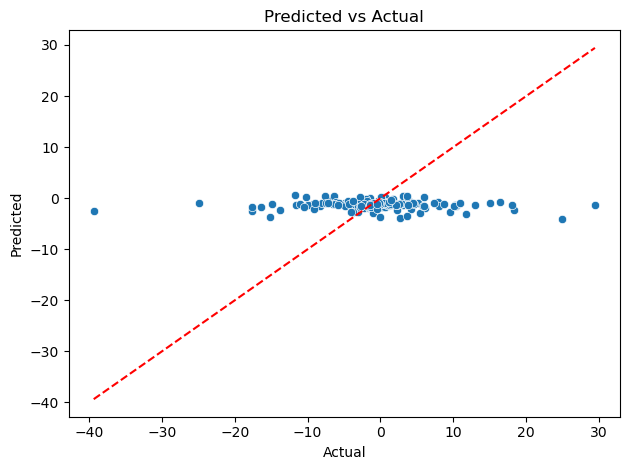

✅ Model saved to: /home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Mean/Reg_Analysis_FNN_PCA/models/fnn_best_model.pt
✅ Hyperparameters saved to: /home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Mean/Reg_Analysis_FNN_PCA/results/best_hyperparameters.txt
✅ Predictions saved to: /home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Mean/Reg_Analysis_FNN_PCA/results/test_predictions.csv


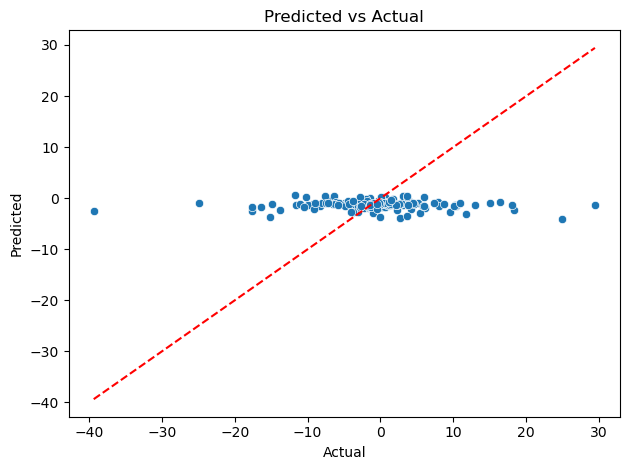

✅ Plot saved to: /home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Mean/Reg_Analysis_FNN_PCA/plots/fnn_optuna_predicted_vs_actual.png


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

# --- Config ---
csv_path = "/home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Median/Cells_Centroid_Velocity_TrueLabel_MA_Median_5.csv"
# shape_features = ['Area_MA', 'Perimeter_MA', 'Extent_MA', 'Solidity_MA','Compactness_MA', 'Elongation_MA', 'Circularity_MA', 'Convexity_MA']
shape_features = ['Area_MA',  'Extent_MA', 'Solidity_MA','Compactness_MA', 'Circularity_MA']
target_column = "X_Centroid_Velocity_MA"

# --- Load and preprocess data ---
df = pd.read_csv(csv_path).dropna(subset=shape_features + [target_column])
X = df[shape_features].values
y = df[target_column].values.reshape(-1, 1)

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.125, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# --- FNN Model with Dropout and BatchNorm ---
class FNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout=0.2):
        super(FNN, self).__init__()
        layers = []
        for i in range(len(hidden_sizes)):
            in_dim = input_size if i == 0 else hidden_sizes[i - 1]
            layers.append(nn.Linear(in_dim, hidden_sizes[i]))
            layers.append(nn.BatchNorm1d(hidden_sizes[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout))
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# --- Training and evaluation ---
def train_eval_fnn(X_train, y_train, X_val, y_val, input_size, hidden_sizes, lr, batch_size, epochs, dropout, weight_decay):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FNN(input_size=input_size, hidden_sizes=hidden_sizes, dropout=dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    X_train_tensor = torch.tensor(X_train).float().to(device)
    y_train_tensor = torch.tensor(y_train).float().to(device)
    X_val_tensor = torch.tensor(X_val).float().to(device)
    y_val_tensor = torch.tensor(y_val).float().to(device)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(epochs):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(X_val_tensor).cpu().numpy().flatten()
        true = y_val_tensor.cpu().numpy().flatten()
        r2 = r2_score(true, preds)
    return r2, model

# --- Optuna Objective Function ---
def objective(trial):
    hidden_layer_options = [(256, 128, 64), (128, 64, 32), (64, 32), (64, 32, 16)]
    hidden_sizes = trial.suggest_categorical("hidden_sizes", hidden_layer_options)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    epochs = trial.suggest_categorical("epochs", [100, 200, 300])

    r2, _ = train_eval_fnn(X_train_pca, y_train, X_val_pca, y_val, input_size=X_train_pca.shape[1],
                           hidden_sizes=hidden_sizes, lr=lr, batch_size=batch_size,
                           epochs=epochs, dropout=dropout, weight_decay=weight_decay)
    return -r2

# --- Run Optuna Study ---
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("\n✅ Best R²:", -study.best_value)
print("✅ Best hyperparameters:", study.best_params)

# --- Train final model on full training set ---
best_params = study.best_params
final_model = FNN(input_size=X_train_pca.shape[1], hidden_sizes=best_params['hidden_sizes'], dropout=best_params['dropout'])
optimizer = optim.Adam(final_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_model.to(device)

X_combined = np.vstack((X_train_pca, X_val_pca))
y_combined = np.vstack((y_train, y_val))
X_combined_tensor = torch.tensor(X_combined).float().to(device)
y_combined_tensor = torch.tensor(y_combined).float().to(device)
X_test_tensor = torch.tensor(X_test_pca).float().to(device)
y_test_tensor = torch.tensor(y_test).float().to(device)

train_loader = DataLoader(TensorDataset(X_combined_tensor, y_combined_tensor), batch_size=best_params['batch_size'], shuffle=True)

for epoch in range(best_params['epochs']):
    final_model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = final_model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

final_model.eval()
with torch.no_grad():
    preds = final_model(X_test_tensor).cpu().numpy().flatten()
    y_true = y_test_tensor.cpu().numpy().flatten()
    r2 = r2_score(y_true, preds)
    mse = mean_squared_error(y_true, preds)

print(f"\n🏆 Final Model — MSE: {mse:.4f} | R²: {r2:.4f}")

# --- Plot Predicted vs Actual ---
sns.scatterplot(x=y_true, y=preds)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], '--r')
plt.title("Predicted vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.savefig("fnn_optuna_predicted_vs_actual.png")
plt.show()



# --- Define output directory ---
output_root = "/home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Median/Reg_Analysis_FNN"
os.makedirs(f"{output_root}/models", exist_ok=True)
os.makedirs(f"{output_root}/results", exist_ok=True)
os.makedirs(f"{output_root}/plots", exist_ok=True)

# --- Save final model ---
model_path = f"{output_root}/models/fnn_best_model.pt"
torch.save(final_model.state_dict(), model_path)
print(f"✅ Model saved to: {model_path}")

# --- Save best hyperparameters ---
params_path = f"{output_root}/results/best_hyperparameters.txt"
with open(params_path, "w") as f:
    for k, v in best_params.items():
        f.write(f"{k}: {v}\n")
print(f"✅ Hyperparameters saved to: {params_path}")

# --- Save test predictions ---
pred_df = pd.DataFrame({
    "Actual": y_true,
    "Predicted": preds
})
pred_path = f"{output_root}/results/test_predictions.csv"
pred_df.to_csv(pred_path, index=False)
print(f"✅ Predictions saved to: {pred_path}")

# --- Plot and save Predicted vs Actual ---
plt.figure()
sns.scatterplot(x=y_true, y=preds)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], '--r')
plt.title("Predicted vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plot_path = f"{output_root}/plots/fnn_optuna_predicted_vs_actual.png"
plt.savefig(plot_path)
plt.show()
print(f"✅ Plot saved to: {plot_path}")


[I 2025-04-22 06:49:57,487] A new study created in memory with name: no-name-618a8692-af9c-4c89-9ab6-25713909416b
/home/MinaHossain/anaconda3/envs/Shp_chc/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128, 64) which is of type tuple.
  warnings.warn(message)
/home/MinaHossain/anaconda3/envs/Shp_chc/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64, 32) which is of type tuple.
  warnings.warn(message)
/home/MinaHossain/anaconda3/envs/Shp_chc/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 32) which is of type tuple.
  warning


✅ Best R²: 0.07348757982254028
✅ Best hyperparameters: {'hidden_sizes': (256, 128, 64), 'lr': 0.0002012719159887882, 'dropout': 0.35287893197229386, 'weight_decay': 8.97569527528788e-05, 'batch_size': 8, 'epochs': 300}

🏆 Final Model — MSE: 29.5909 | R²: 0.0438


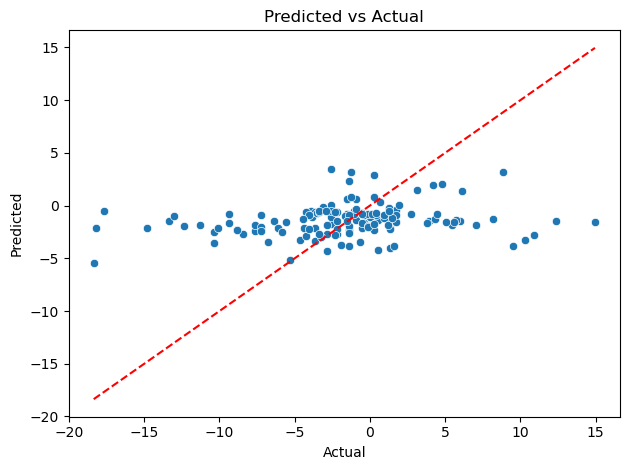

✅ Model saved to: /home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Median/Reg_Analysis_FNN/models/fnn_best_model.pt
✅ Hyperparameters saved to: /home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Median/Reg_Analysis_FNN/results/best_hyperparameters.txt
✅ Predictions saved to: /home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Median/Reg_Analysis_FNN/results/test_predictions.csv


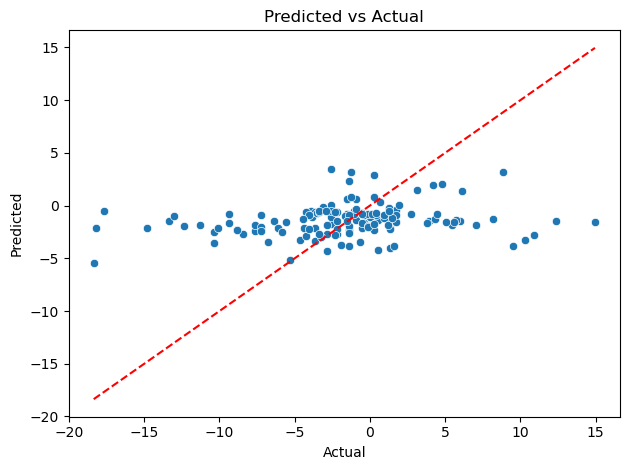

✅ Plot saved to: /home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Median/Reg_Analysis_FNN/plots/fnn_optuna_predicted_vs_actual.png


In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

# --- Config ---
csv_path = "/home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Median/Cells_Centroid_Velocity_TrueLabel_MA_Median_5.csv"
# shape_features = ['Area_MA', 'Perimeter_MA', 'Extent_MA', 'Solidity_MA','Compactness_MA', 'Elongation_MA', 'Circularity_MA', 'Convexity_MA']
shape_features = ['Area_MA',  'Extent_MA', 'Solidity_MA','Compactness_MA', 'Circularity_MA']
target_column = "X_Centroid_Velocity_MA"

# --- Load and preprocess data ---
df = pd.read_csv(csv_path).dropna(subset=shape_features + [target_column])
X = df[shape_features].values
y = df[target_column].values.reshape(-1, 1)

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.125, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# --- FNN Model with Dropout and BatchNorm ---
class FNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout=0.2):
        super(FNN, self).__init__()
        layers = []
        for i in range(len(hidden_sizes)):
            in_dim = input_size if i == 0 else hidden_sizes[i - 1]
            layers.append(nn.Linear(in_dim, hidden_sizes[i]))
            layers.append(nn.BatchNorm1d(hidden_sizes[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout))
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# --- Training and evaluation ---
def train_eval_fnn(X_train, y_train, X_val, y_val, input_size, hidden_sizes, lr, batch_size, epochs, dropout, weight_decay):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FNN(input_size=input_size, hidden_sizes=hidden_sizes, dropout=dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    X_train_tensor = torch.tensor(X_train).float().to(device)
    y_train_tensor = torch.tensor(y_train).float().to(device)
    X_val_tensor = torch.tensor(X_val).float().to(device)
    y_val_tensor = torch.tensor(y_val).float().to(device)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(epochs):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(X_val_tensor).cpu().numpy().flatten()
        true = y_val_tensor.cpu().numpy().flatten()
        r2 = r2_score(true, preds)
    return r2, model

# --- Optuna Objective Function ---
def objective(trial):
    hidden_layer_options = [(256, 128, 64), (128, 64, 32), (64, 32), (64, 32, 16)]
    hidden_sizes = trial.suggest_categorical("hidden_sizes", hidden_layer_options)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    epochs = trial.suggest_categorical("epochs", [100, 200, 300])

    r2, _ = train_eval_fnn(X_train_pca, y_train, X_val_pca, y_val, input_size=X_train_pca.shape[1],
                           hidden_sizes=hidden_sizes, lr=lr, batch_size=batch_size,
                           epochs=epochs, dropout=dropout, weight_decay=weight_decay)
    return -r2

# --- Run Optuna Study ---
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("\n✅ Best R²:", -study.best_value)
print("✅ Best hyperparameters:", study.best_params)

# --- Train final model on full training set ---
best_params = study.best_params
final_model = FNN(input_size=X_train_pca.shape[1], hidden_sizes=best_params['hidden_sizes'], dropout=best_params['dropout'])
optimizer = optim.Adam(final_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_model.to(device)

X_combined = np.vstack((X_train_pca, X_val_pca))
y_combined = np.vstack((y_train, y_val))
X_combined_tensor = torch.tensor(X_combined).float().to(device)
y_combined_tensor = torch.tensor(y_combined).float().to(device)
X_test_tensor = torch.tensor(X_test_pca).float().to(device)
y_test_tensor = torch.tensor(y_test).float().to(device)

train_loader = DataLoader(TensorDataset(X_combined_tensor, y_combined_tensor), batch_size=best_params['batch_size'], shuffle=True)

for epoch in range(best_params['epochs']):
    final_model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = final_model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

final_model.eval()
with torch.no_grad():
    preds = final_model(X_test_tensor).cpu().numpy().flatten()
    y_true = y_test_tensor.cpu().numpy().flatten()
    r2 = r2_score(y_true, preds)
    mse = mean_squared_error(y_true, preds)

print(f"\n🏆 Final Model — MSE: {mse:.4f} | R²: {r2:.4f}")

# --- Plot Predicted vs Actual ---
sns.scatterplot(x=y_true, y=preds)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], '--r')
plt.title("Predicted vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.savefig("fnn_optuna_predicted_vs_actual.png")
plt.show()



# --- Define output directory ---
output_root = "/home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Median/Reg_Analysis_FNN"
os.makedirs(f"{output_root}/models", exist_ok=True)
os.makedirs(f"{output_root}/results", exist_ok=True)
os.makedirs(f"{output_root}/plots", exist_ok=True)

# --- Save final model ---
model_path = f"{output_root}/models/fnn_best_model.pt"
torch.save(final_model.state_dict(), model_path)
print(f"✅ Model saved to: {model_path}")

# --- Save best hyperparameters ---
params_path = f"{output_root}/results/best_hyperparameters.txt"
with open(params_path, "w") as f:
    for k, v in best_params.items():
        f.write(f"{k}: {v}\n")
print(f"✅ Hyperparameters saved to: {params_path}")

# --- Save test predictions ---
pred_df = pd.DataFrame({
    "Actual": y_true,
    "Predicted": preds
})
pred_path = f"{output_root}/results/test_predictions.csv"
pred_df.to_csv(pred_path, index=False)
print(f"✅ Predictions saved to: {pred_path}")

# --- Plot and save Predicted vs Actual ---
plt.figure()
sns.scatterplot(x=y_true, y=preds)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], '--r')
plt.title("Predicted vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plot_path = f"{output_root}/plots/fnn_optuna_predicted_vs_actual.png"
plt.savefig(plot_path)
plt.show()
print(f"✅ Plot saved to: {plot_path}")


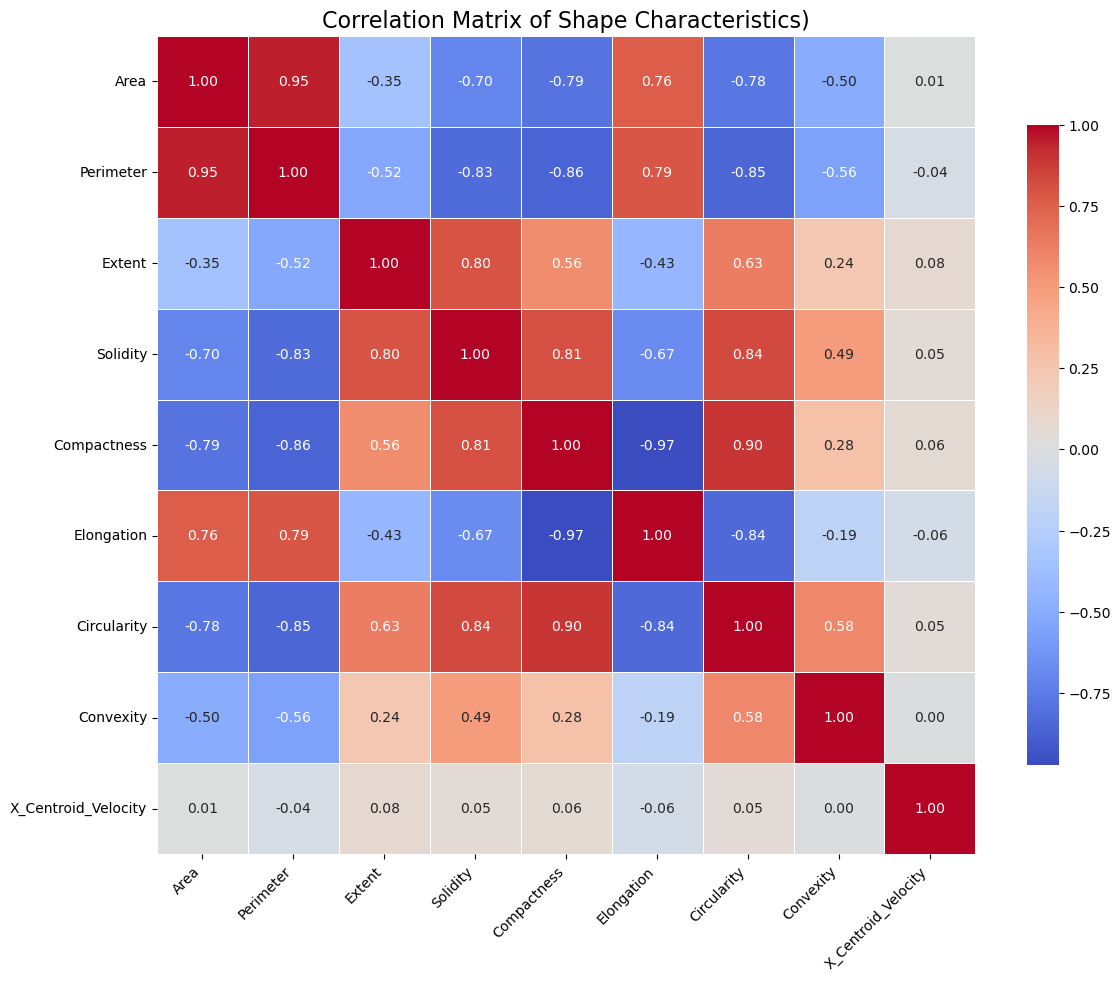

In [10]:

# Define paths
# window_size = 5  # Change if needed

# output_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Track_New_Output"
# csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_Original_TrueLabel_Median_{window_size}.csv")



# output_directory ="/home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Median/Reg_Analysis_FNN"
# csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_TrueLabel_MA_Mean_{window_size}.csv")


output_directory ="/home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Median/Reg_Analysis_FNN"
csv_path="/home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Median/Cells_Centroid_Velocity_TrueLabel_MA_Median_5.csv"

# Load the CSV
df = pd.read_csv(csv_path)

# Define the columns of interest
columns_of_interest = [ "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity","X_Centroid_Velocity"]

# columns_of_interest = [
#     "Area", "Perimeter", "Extent", "Solidity", "Compactness",
#     "Elongation", "Circularity", "Convexity",
#     "X_Centroid_Velocity", "Y_Centroid_Velocity"]

# Compute the correlation matrix
correlation_matrix = df[columns_of_interest].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True,
            cbar_kws={"shrink": 0.75}, linewidths=0.5)

plt.title(f"Correlation Matrix of Shape Characteristics)", fontsize=16)
# plt.title(f"Correlation Matrix (Original Shape Characteristics)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save the plot (optional)
plot_path = os.path.join(output_directory, f"Correlation_Matrix_MA.png")
# plot_path = os.path.join(output_directory, f"Correlation_Matrix_Original.png")
# plt.savefig(plot_path, dpi=300)

# Show plot
plt.show()


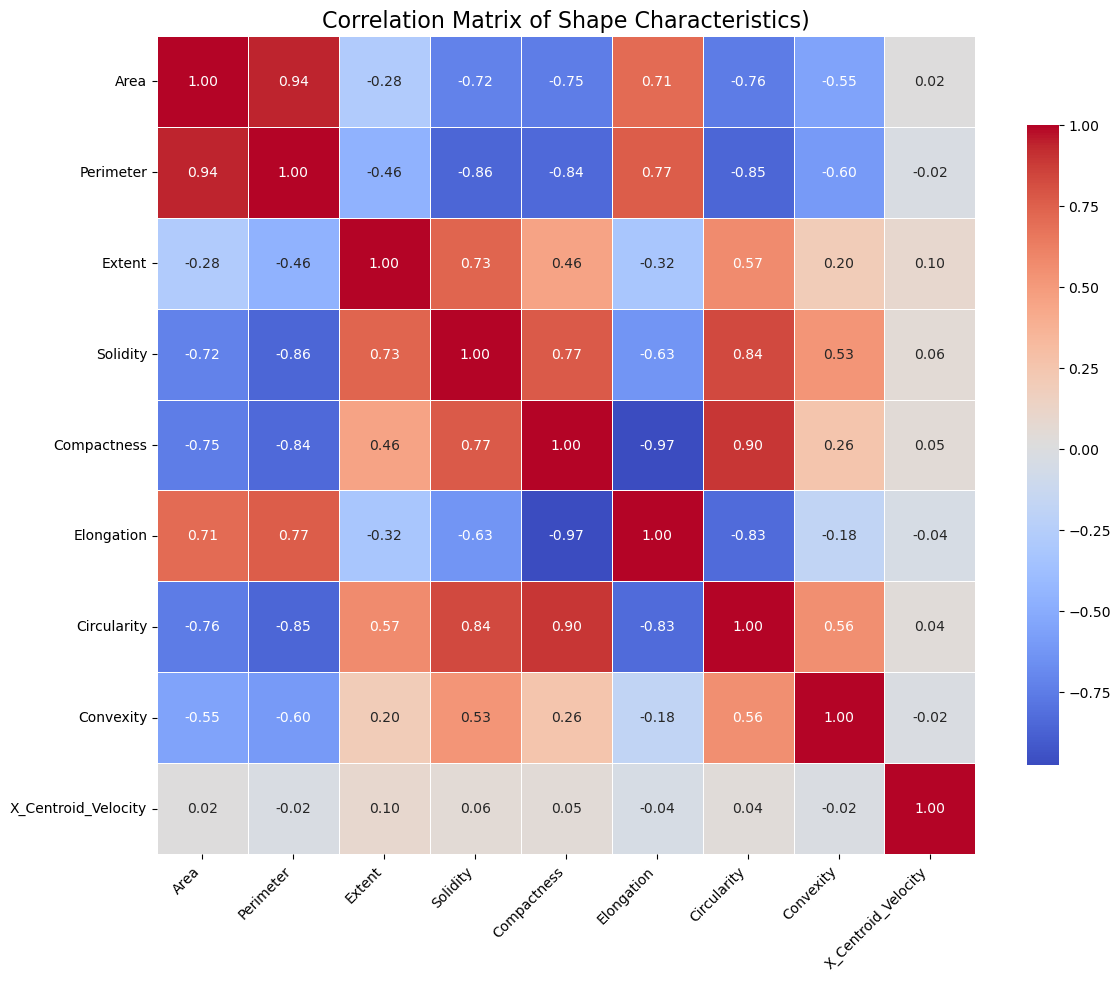

In [13]:

# Define paths
# window_size = 5  # Change if needed

# output_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Track_New_Output"
# csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_Original_TrueLabel_Median_{window_size}.csv")



# output_directory ="/home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Median/Reg_Analysis_FNN"
# csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_TrueLabel_MA_Mean_{window_size}.csv")


output_directory ="/home/MinaHossain/EmbedTrack/Track_HP4_Result_Shape/Median/Reg_Analysis_FNN_PCA"
csv_path="/home/MinaHossain/EmbedTrack/Track_HP4_Result_Shape/Median/Cells_Centroid_Velocity_TrueLabel_MA_Median_5.csv"

# Load the CSV
df = pd.read_csv(csv_path)

# Define the columns of interest
columns_of_interest = [ "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity","X_Centroid_Velocity"]

# columns_of_interest = [
#     "Area", "Perimeter", "Extent", "Solidity", "Compactness",
#     "Elongation", "Circularity", "Convexity",
#     "X_Centroid_Velocity", "Y_Centroid_Velocity"]

# Compute the correlation matrix
correlation_matrix = df[columns_of_interest].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True,
            cbar_kws={"shrink": 0.75}, linewidths=0.5)

plt.title(f"Correlation Matrix of Shape Characteristics)", fontsize=16)
# plt.title(f"Correlation Matrix (Original Shape Characteristics)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save the plot (optional)
plot_path = os.path.join(output_directory, f"Correlation_Matrix_MA.png")
plot_path = os.path.join(output_directory, f"Correlation_Matrix_Original.png")
plt.savefig(plot_path, dpi=300)

# Show plot
plt.show()


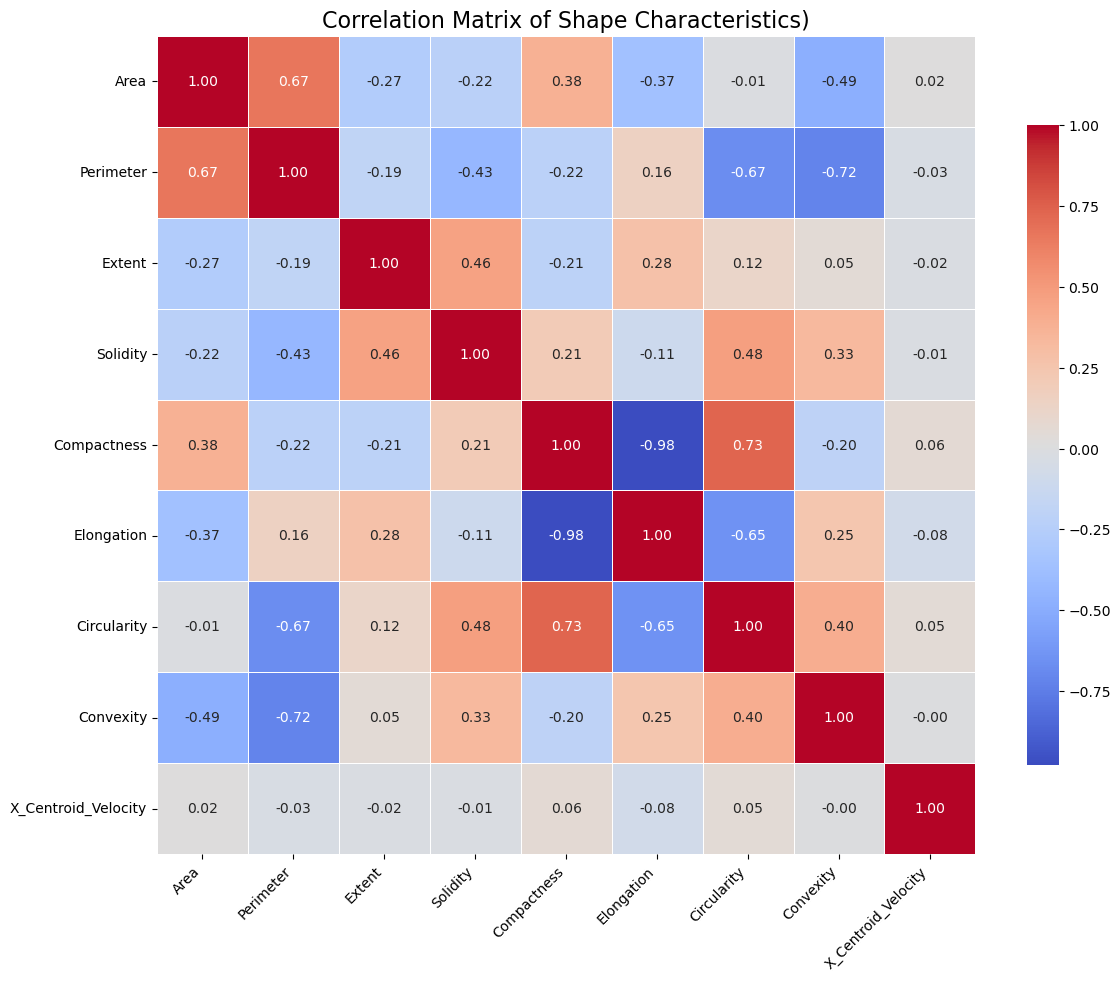

In [14]:

# Define paths
# window_size = 5  # Change if needed

# output_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Track_New_Output"
# csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_Original_TrueLabel_Median_{window_size}.csv")



# output_directory ="/home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Median/Reg_Analysis_FNN"
# csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_TrueLabel_MA_Mean_{window_size}.csv")


output_directory ="/home/MinaHossain/EmbedTrack/Track_EMBD_Result_Shape/Median/Reg_Analysis_FNN_PCA"
csv_path="/home/MinaHossain/EmbedTrack/Track_EMBD_Result_Shape/Median/Cells_Centroid_Velocity_TrueLabel_MA_Median_5.csv"

# Load the CSV
df = pd.read_csv(csv_path)

# Define the columns of interest
columns_of_interest = [ "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity","X_Centroid_Velocity"]

# columns_of_interest = [
#     "Area", "Perimeter", "Extent", "Solidity", "Compactness",
#     "Elongation", "Circularity", "Convexity",
#     "X_Centroid_Velocity", "Y_Centroid_Velocity"]

# Compute the correlation matrix
correlation_matrix = df[columns_of_interest].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True,
            cbar_kws={"shrink": 0.75}, linewidths=0.5)

plt.title(f"Correlation Matrix of Shape Characteristics)", fontsize=16)
# plt.title(f"Correlation Matrix (Original Shape Characteristics)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save the plot (optional)
plot_path = os.path.join(output_directory, f"Correlation_Matrix_MA.png")
plot_path = os.path.join(output_directory, f"Correlation_Matrix_Original.png")
plt.savefig(plot_path, dpi=300)

# Show plot
plt.show()
